In [15]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

In [ ]:
# Define problem parameters
dt = 0.02
tf = 10.0

N = int(tf/dt)                         # Horizon length
nx = 2                                 # State dimension
nu = 1                                 # Control dimension

# Discrete-time system dynamics: x[k+1] = A*x[k] + B*u[k]
Ac = np.array([[0.0, 1.0],
               [0.0, 0.0]])
Bc = np.array([[0.0],
               [1.0]])

M = np.zeros((nx + nu, nx + nu))
M[:nx, :nx] = Ac
M[:nx, nx:] = Bc
Md = expm(M * dt)
Ad = Md[:nx, :nx]
Bd = Md[:nx, nx:]

# Cost matrices
Q = np.diag([1.0, 0.1])        # State cost
R = np.diag([1.0])            # Control cost
Qf = Q                         # Terminal cost

x0_val = np.array([10.0, 0.0])  # Initial condition

In [ ]:
X = ca.MX.sym('X', nx, N + 1)
U = ca.MX.sym('U', nu, N)

cost = 0
g = []

for k in range(N):
    xk = X[:, k]
    uk = U[:, k]
    xk_next = X[:, k+1]

    # Stage cost
    cost += ca.mtimes([xk.T, Q, xk]) + ca.mtimes([uk.T, R, uk])

    # Dynamics constraint
    xk_next_pred = Ad @ xk + Bd @ uk
    g.append(xk_next - xk_next_pred)

# Terminal cost
cost += ca.mtimes([X[:, N].T, Qf, X[:, N]])

# Initial condition constraint
g.insert(0, X[:, 0] - x0_val)

g_flat = ca.vertcat(*g)

# Define decision variables
opt_vars = ca.vertcat(
    ca.reshape(X, nx * (N + 1), 1),
    ca.reshape(U, nu * N, 1)
)

In [ ]:
# Create NLP
nlp = {'x': opt_vars, 'f': cost, 'g': g_flat}

# Solver
solver = ca.nlpsol('solver', 'ipopt', {'x': opt_vars, 'f': cost, 'g': g_flat},
                   {'ipopt.print_level': 0, 'print_time': 0})

# Initial guess
x0_guess = np.tile(np.zeros((nx, 1)), (N+1, 1))
u0_guess = np.tile(np.zeros((nu, 1)), (N, 1))
x0u0 = np.concatenate([x0_guess.flatten(), u0_guess.flatten()])

lbg = ubg = np.zeros(g_flat.shape)

x_min = -ca.inf * np.ones((nx, N + 1))
x_max = ca.inf * np.ones((nx, N + 1))
u_min = -1.0 * np.ones((nu, N))
u_max = 1.0 * np.ones((nu, N))

lbx = np.concatenate([x_min.flatten(), u_min.flatten()])
ubx = np.concatenate([x_max.flatten(), u_max.flatten()])

sol = solver(x0=x0u0, lbg=lbg, ubg=ubg, lbx=lbx, ubx=ubx)

stats = solver.stats()
print(f"Solver statistics:")
print(f"\titer_count: {stats['iter_count']}")
print(f"\treturn_status: {stats['return_status']}")

for k in stats:
    if k.startswith('t_'):
        print(f"\t{k}: {stats[k]}")

Solver statistics:
	iter_count: 24
	return_status: Solve_Succeeded
	t_proc_callback_fun: 0.0
	t_proc_nlp_f: 0.0011870000000000001
	t_proc_nlp_g: 0.001733
	t_proc_nlp_grad: 0.0
	t_proc_nlp_grad_f: 0.0021810000000000006
	t_proc_nlp_hess_l: 0.0038649999999999995
	t_proc_nlp_jac_g: 0.0037710000000000005
	t_wall_callback_fun: 0.0
	t_wall_nlp_f: 0.0011839580000000001
	t_wall_nlp_g: 0.0017370810000000003
	t_wall_nlp_grad: 0.0
	t_wall_nlp_grad_f: 0.002283458
	t_wall_nlp_hess_l: 0.003906167
	t_wall_nlp_jac_g: 0.003790835


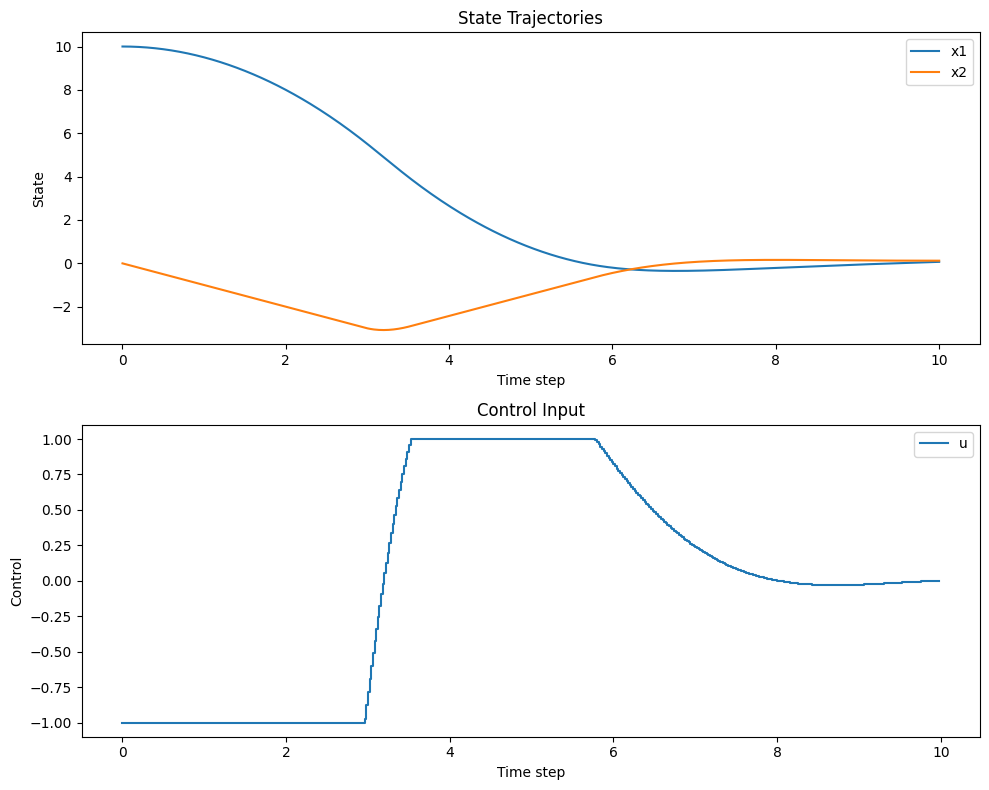

In [36]:
opt = sol['x'].full().flatten()
X_opt = opt[:nx*(N+1)].reshape((N+1, nx))
U_opt = opt[nx*(N+1):].reshape((N, nu))

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ts = np.arange(0, tf + dt, dt)

ax[0].plot(ts, X_opt[:, 0], label='x1')
ax[0].plot(ts, X_opt[:, 1], label='x2')
ax[0].set_title('State Trajectories')
ax[0].set_xlabel('Time step')
ax[0].set_ylabel('State')
ax[0].legend()

ax[1].step(ts[:-1], U_opt[:, 0], label='u', where='post')
ax[1].set_title('Control Input')
ax[1].set_xlabel('Time step')
ax[1].set_ylabel('Control')
ax[1].legend()

plt.tight_layout()
plt.show()